## Image Classfication

#### Dataset selection

https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data

#### Resources I used

https://www.tensorflow.org/tutorials/images/cnn
https://www.kaggle.com/code/victor116/mlp-cnn-bone-break-classification-95-a
https://medium.com/topbots/14-design-patterns-to-improve-your-convolutional-neural-networks-971bb388a082
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import optimizers
from keras import layers
from keras import models
from keras import utils
from keras import callbacks

In [3]:
data_dir = "./Bone Break Classification/"

# Load data set
full_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    subset=None,  # Load entire dataset
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=37
)

Found 1129 files belonging to 10 classes.


In [4]:
class_names = full_data.class_names
class_names_dict = {
    0: 'Avulsion fracture', 
    1: 'Comminuted fracture', 
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

In [5]:
# Data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

full_dataset = full_data.map(lambda x, y: (preprocess(x), y))

In [6]:
# Get train data and labels
x_full = []
y_full = []

for images, labels in full_dataset:
    # Append train data to x_train
    x_full.append(images.numpy())
    
    # Append labels to y_train
    y_full.append(labels.numpy())
    
# Concatenate all the batches to get the full list
x_full = np.concatenate(x_full, axis=0)
y_full = np.concatenate(y_full, axis=0)

In [7]:
# Break full data into train and test

# Define the ratio for splitting (e.g., 90% training, 10% testing)
train_ratio = 0.9

# Calculate the number of samples for training
num_train_samples = int(len(x_full) * train_ratio)

# Shuffle indices to ensure randomization
indices = np.arange(len(x_full))
np.random.shuffle(indices)

# Split the indices into training and testing indices
train_indices = indices[:num_train_samples]
test_indices = indices[num_train_samples:]

# Split the data and labels using the indices
x_train, y_train = x_full[train_indices], y_full[train_indices]
x_test, y_test = x_full[test_indices], y_full[test_indices]


In [30]:
# One-hot encode the train, val data

NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

## CNN

Convolutional Neural Network (CNN) architecture with alternating Conv2D and MaxPooling2D layers is the most basic pattern I could find. It was chosen here to create a benchmark for the other pattern to compare to as informing that second pattern. Initially, Conv2D layers facilitate the extraction of hierarchical features from the input images through convolution operations, progressively learning abstract representations of features. As the network depth increases, these layers capture increasingly complex patterns within the images. Concurrently, MaxPooling2D layers play a crucial role in reducing the dimensions of the feature maps produced by Conv2D layers, thereby decreasing computational complexity while preserving essential information. This dimensionality reduction not only enhances computational efficiency but also (theoretically) mitigates overfitting by retaining only the most important features. The combined effect of convolution and pooling layers gives the network with translation invariance, enabling it to detect patterns regardless of their location in the images. The alternating Conv2D and MaxPooling2D layers form a hierarchical representation of features, starting from simple edges and textures to more intricate shapes and objects, empowering the CNN to autonomously discern meaningful patterns from raw pixel data.

In [23]:
input_layer = layers.Input(shape=(256, 256, 3))

# Convolutional base
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten layer
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer
output_layer = layers.Dense(units=10, activation='softmax')(x)

# Create model
model = models.Model(input_layer, output_layer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       738

In [54]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [55]:
history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
32/32 [==============================] - 36s 1s/step - loss: 2.4392 - accuracy: 0.1339 - val_loss: 2.2716 - val_accuracy: 0.1416
Epoch 2/10
32/32 [==============================] - 33s 1s/step - loss: 2.2399 - accuracy: 0.1713 - val_loss: 2.2555 - val_accuracy: 0.1770
Epoch 3/10
32/32 [==============================] - 33s 1s/step - loss: 2.1216 - accuracy: 0.2293 - val_loss: 2.1995 - val_accuracy: 0.2124
Epoch 4/10
32/32 [==============================] - 33s 1s/step - loss: 1.9043 - accuracy: 0.3140 - val_loss: 2.1834 - val_accuracy: 0.2124
Epoch 5/10
32/32 [==============================] - 34s 1s/step - loss: 1.6460 - accuracy: 0.4222 - val_loss: 2.2830 - val_accuracy: 0.2566
Epoch 6/10
32/32 [==============================] - 33s 1s/step - loss: 1.3873 - accuracy: 0.5236 - val_loss: 2.2240 - val_accuracy: 0.3274
Epoch 7/10
32/32 [==============================] - 33s 1s/step - loss: 1.1358 - accuracy: 0.6270 - val_loss: 2.4797 - val_accuracy: 0.2832
Epoch 8/10
32/32 [==

In [56]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

In [57]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 210ms/step - loss: 2.8585 - accuracy: 0.3451


[2.858515739440918, 0.3451327383518219]

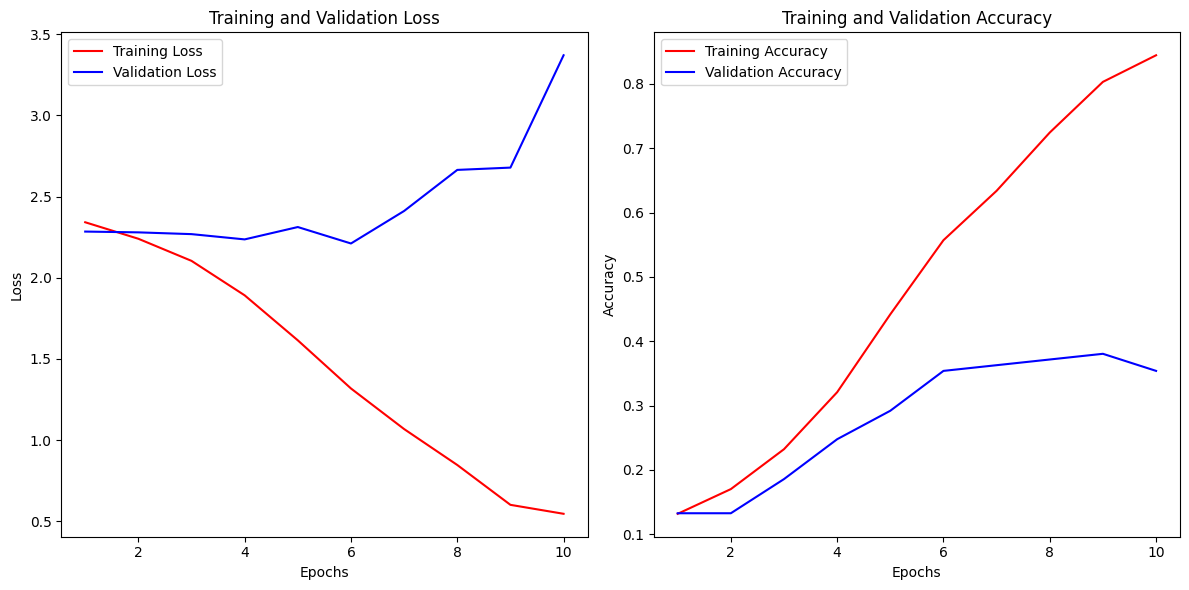

In [33]:
# Plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Accuracy was the best metric to evalute the model, since we only care about how often the image is correctly assesed. The accuracy achieved was very low, around 35%. This isn't very surpising. The image set contains 1129 examples to be drawn from. This would usually be enough but since, say, a hairline fracture, can happen on any bone, the model has to be able to identify it regardless of where it occurs. With 10 possible types of frature and 206 bones in the human body, low accuracy on a simple model isn't surprising. Additionally, thanks to the graphs of loss and accuracy we can see that the model suffers from some pretty serious overfitting.

## ResNet50

ResNet50 an example of Residual Net was chosen because because of it's (allegedy) good performance and it's resistance to overfitting. The skip connections in ResNet act as a form of implicit regularization, encouraging the model to learn simpler representations of the data. Additionally, ResNet architectures often incorporate batch normalization layers, which further stabilize training and act as a form of regularization by normalizing the activations. Also, ResNet50 has 50 layers, which means a very deep analysis of the data can be performed. Despite this depth, ResNet models have been shown to be relatively resistant to overfitting, thanks to  residual learning and regularization techniques.

In [48]:
# Load the pretrained ResNet50 model
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet'
)

# Add custom top layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(units=10, activation='softmax')(x)

# Create the new model
model2 = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model2.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test)
)


113
113
1016
1016
(113, 256, 256, 3)
(113, 10)
(1016, 256, 256, 3)
(1016, 10)
Epoch 1/10
32/32 [==============================] - 317s 10s/step - loss: 2.4158 - accuracy: 0.1516 - val_loss: 28.3962 - val_accuracy: 0.1062
Epoch 2/10
32/32 [==============================] - 167s 5s/step - loss: 2.2599 - accuracy: 0.1555 - val_loss: 2.3003 - val_accuracy: 0.1150
Epoch 3/10
32/32 [==============================] - 171s 5s/step - loss: 2.1896 - accuracy: 0.1900 - val_loss: 4.2582 - val_accuracy: 0.0796
Epoch 4/10
32/32 [==============================] - 170s 5s/step - loss: 2.1093 - accuracy: 0.2293 - val_loss: 2.4063 - val_accuracy: 0.1327
Epoch 5/10
32/32 [==============================] - 214s 7s/step - loss: 1.9966 - accuracy: 0.3110 - val_loss: 2.3621 - val_accuracy: 0.0708
Epoch 6/10
32/32 [==============================] - 197s 6s/step - loss: 1.9360 - accuracy: 0.3130 - val_loss: 23.6784 - val_accuracy: 0.0796
Epoch 7/10
32/32 [==============================] - 189s 6s/step - loss: 

In [49]:
model2.evaluate(x_test, y_test)

4/4 [==============================] - 7s 2s/step - loss: 3.0126 - accuracy: 0.1947


[3.0125904083251953, 0.1946902722120285]

In [50]:
train_loss = history2.history["loss"]
train_accuracy = history2.history["accuracy"]
val_loss = history2.history["val_loss"]
val_accuracy = history2.history["val_accuracy"]

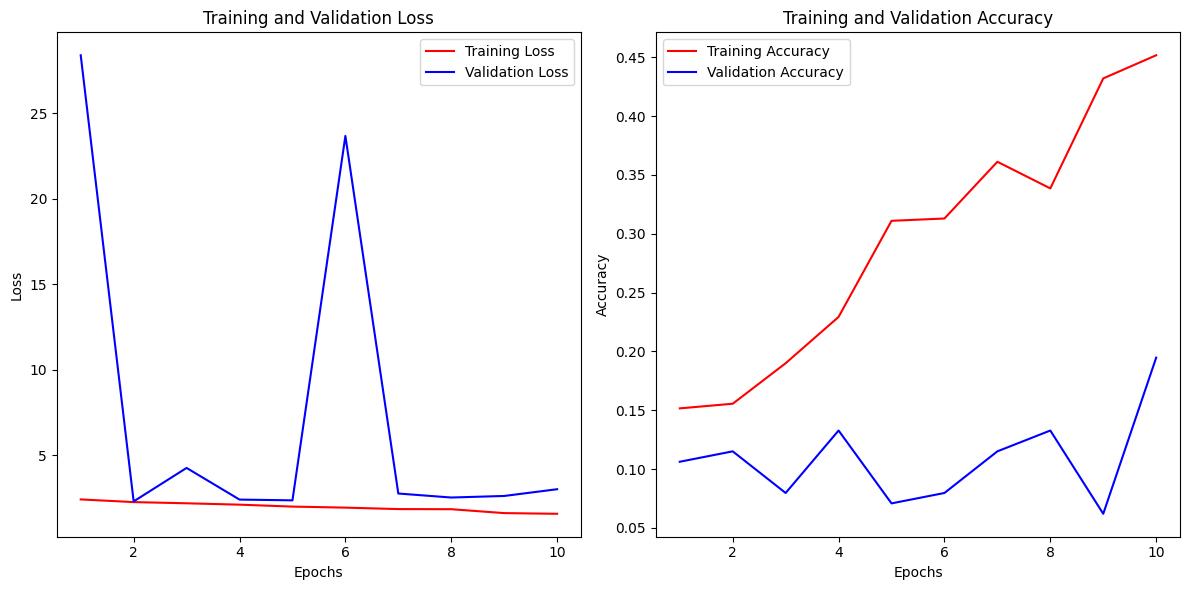

In [51]:
# Plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Wow! That's even worse, and it took around 20 times longer to train the model and it performed about half as well. Overfitting seems to no longer be an issue as the accuracy is quite low on the training data as well. Also the loss functions, baring one large spike, don't deviate much. So, my best guess is that the model is much better due to its complexity but the pretrained ResNet50 model, initialized with weights from ImageNet, isn't well-suited for this data and there either isn't enough data, or time, for the adjustments to be made.

## Data augmentation

Okay, so how will data augmentation affect results? Let's randomly rotate some of the images fed to the first model and see how it performs.

(Please see visual-classification-p3.ipynb)